# Pachyderm-Seldon Integration: Version Controlled Models
 
> By Dr. Phil Winder, CEO of [Winder Research](https://WinderResearch.com)

[Pachyderm](https://pachyderm.io/) is a data science platform that combines Data Lineage with End-to-End Pipelines. [Seldon-Core](https://www.seldon.io/tech/products/core/) is an open-source platform for rapidly deploying machine learning models.

This notebook specialises in showing you how you can automate the provisioning of a Seldon deployment using Pachyderm pipelines when new training data enters a Pachyderm repository. Additionally, this example uses Pachyderm's S3 gateway feature to provide convenient access to version controlled model parameters.

### Highlights

In ML, provenance describes the ability to pinpoint all of the factors that contributed to a deployed model. People often talk about the provenance of the data, but what about the provenance of a model? Not only does model provenance provide the ability to do post-mortems on bad models, it is also an integral to GitOps, which provides repeatability, and resiliency.

Similary, automation is the art of encoding a process to produce a deployed model. Without a process you can't have provenance, since several people will peform the task in several different ways. If you can automate the process then you can remove the human-induced variance entirelly and improve efficiency to boot.

### Example Situation

Imagine you work for an organization that uses the UK's retail services index (RSI), similar to the consumer prices index in the US, to help predict demand for your products. The RSI is often quoted as a proxy for consumer demand, so you could base your stock levels upon a future RSI prediction.

But the RSI is a dynamic index. It is influenced by external events, like COVID-19, for example. Because of this you want to make sure that your model is up to date. One potential solution is scheduled retraining, but this is a poor proxy because it is not reactive. Scheduling is a poor-mans proxy because you end up retraining too much, which adds risk, or too little, where important changes to the model parameters are delayed.

The solution then, if you pardon the buzz-word, is to become data-driven. When new data is available, it should kick-off a new training run. That should result in a model which is then automatically deployed. And ideally, all of this should be tracked and version controlled for provenance.

I achieve this with two Pachyderm pipelines (on for training, one for deployment) and a simple custom Seldon deployment to serve the model. From an outsiders perspective, this is still a pure Seldon solution. But internally you will have full data-driven automation and provenance. This is depicted in the image below.

![overview image](./images/pachyderm-cd4ml.png)

## Prerequisites

This is a follow-on example from the simpler Pachyderm demo. I recommend that you review that first before following this one.

 * A kubernetes cluster with kubectl configured
 * [A seldon-core cluster installed and configured](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html)
 * Pachyderm's `pachctl` binary installed following the [official documentation](https://docs.pachyderm.com/latest/getting_started/local_installation/#install-pachctl)
 * The ability to build docker images and push them to your cluster

Pachyderm is controlled and deployed via the `pachctl`. This document assumes that you have version `1.11.8` installed, although it should work with any `1.x.x` version.

In [1]:
!pachctl version --client-only
!kubectl get po -A

1.11.8
NAMESPACE            NAME                                          READY   STATUS    RESTARTS   AGE
kube-system          coredns-f9fd979d6-5ddkn                       1/1     Running   0          7m53s
kube-system          coredns-f9fd979d6-lbz46                       1/1     Running   0          7m53s
kube-system          etcd-kind-control-plane                       1/1     Running   0          8m1s
kube-system          kindnet-pfxnk                                 1/1     Running   0          7m53s
kube-system          kube-apiserver-kind-control-plane             1/1     Running   0          8m1s
kube-system          kube-controller-manager-kind-control-plane    1/1     Running   0          8m1s
kube-system          kube-proxy-s5z84                              1/1     Running   0          7m53s
kube-system          kube-scheduler-kind-control-plane             1/1     Running   0          8m1s
kube-system          seldon-spartakus-volunteer-5b57b95596-7hjb5   1/1     Runnin

## 1. Install Pachyderm

First install a Pachyderm cluster. This uses the standard `local` install method which creates a cluster using your current kubernetes context.

The second step is to give all Pachyderm pielines permission to deploy the `SeldonDeployment` to the `seldon` namespace. If you alter the deployment you will need to check that you provide the correct permissions.

In [2]:
!kubectl create ns pachyderm
!pachctl deploy local --no-expose-docker-socket --no-dashboard --namespace pachyderm
!kubectl rollout status deployment -n pachyderm pachd

namespace/pachyderm created
serviceaccount/pachyderm created
serviceaccount/pachyderm-worker created
clusterrole.rbac.authorization.k8s.io/pachyderm created
clusterrolebinding.rbac.authorization.k8s.io/pachyderm created
role.rbac.authorization.k8s.io/pachyderm-worker created
rolebinding.rbac.authorization.k8s.io/pachyderm-worker created
deployment.apps/etcd created
service/etcd created
service/pachd created
service/pachd-peer created
deployment.apps/pachd created
secret/pachyderm-storage-secret created

Pachyderm is launching. Check its status with "kubectl get all"

Waiting for deployment spec update to be observed...
Waiting for deployment "pachd" rollout to finish: 0 of 1 updated replicas are available...
deployment "pachd" successfully rolled out


In [91]:
%%writefile rbac.yaml
---
kind: Role
apiVersion: rbac.authorization.k8s.io/v1
metadata:
  namespace: seldon
  name: allow-all
rules:
# To write the Pachyderm S3 gateway secret
- apiGroups: ["", ]
  resources: ["secrets"]
  verbs: ["*"]
# To create the Seldon deployment 
- apiGroups: ["machinelearning.seldon.io", ]
  resources: ["seldondeployments"]
  verbs: ["*"]
# So Helm can do an upgrade
- apiGroups: ["", ]
  resources: ["serviceaccounts"]
  verbs: ["*"]
---
apiVersion: rbac.authorization.k8s.io/v1
kind: RoleBinding
metadata:
  name: pachyderm-deployer
  namespace: seldon
subjects:
- kind: ServiceAccount
  name: pachyderm-worker
  namespace: pachyderm
roleRef:
  kind: Role
  name: allow-all
  apiGroup: rbac.authorization.k8s.io

Overwriting rbac.yaml


In [92]:
!kubectl apply -f rbac.yaml

role.rbac.authorization.k8s.io/allow-all configured
rolebinding.rbac.authorization.k8s.io/pachyderm-deployer unchanged


## 2. Add Initial Training Data and Build the Necessary Containers

> Note: If you are using a non-standard Pachyderm namespace, you will need to run `pachctl port-forward` in a separate terminal

Below I create a training data repository and populate it with some initial RSI data. This data comes from the [UK's Office of National Statistics](https://www.ons.gov.uk/businessindustryandtrade/retailindustry/timeseries/j5c4/drsi). I have altered the original data by adding headers, removing quotes for floats, and organized into pre, mid, and post corona datasets for demonstration purposes.

You'll have to wait a moment to see the data. I want to setup the automation so you can see it in action and first we need to create a data repo.

In [93]:
!pachctl create repo rsi_data

In [94]:
!cd data && pachctl put file rsi_data@master:/rsi.csv -f rsi_before.csv

rsi_before.csv: 1.17 KiB / 1.17 KiB [=========================] 100.00% ? p/s 0s


In [95]:
!pachctl list repo

NAME     CREATED                SIZE (MASTER) DESCRIPTION 
rsi_data Less than a second ago 1.173KiB                  


In [96]:
!pachctl list file rsi_data@master

NAME     TYPE SIZE     
/rsi.csv file 1.173KiB 


There are three containers used in this demo, one to train, one to deploy and the custom seldon deployment. You'll need to make sure that these containers are present in this cluster. I provide a script to upload to a local `kind` cluster but if you're using something else, you'll have to upload those containers yourself.

In [9]:
!make kind_load

make -C RSIServing build
docker build . -t seldonio/pachyderm-rsi-server:0.1.0
Sending build context to Docker daemon  7.168kB
Step 1/6 : FROM python:3.8-slim
 ---> be5d294735c6
Step 2/6 : RUN pip install pandas==1.1.4 statsmodels==0.12.1 seldon-core==1.5.0 joblib==1.0.0 minio==7.0.0
 ---> Running in 06fb3520d480
  Created wheel for Flask-OpenTracing: filename=Flask_OpenTracing-1.1.0-py3-none-any.whl size=9069 sha256=58f1bef06ac3b2e2da1e6b13ba7550d4fee548fc78c545add7b4d0b8c7cc76af
  Stored in directory: /root/.cache/pip/wheels/f2/fc/27/9dd7ae47db91620be849e6479d5f3d44005a1304b70906d2b0
  Created wheel for jaeger-client: filename=jaeger_client-4.3.0-py3-none-any.whl size=64290 sha256=a418c03173771635ed891049b9ff622ae88633880a52c47f457150f9afd53625
  Stored in directory: /root/.cache/pip/wheels/ef/67/cc/1e96fd3ac7a245e8115eb2fe99f57a01699127e0ee212e4e1d
  Created wheel for opentracing: filename=opentracing-2.4.0-py3-none-any.whl size=51399 sha256=dee02b559488e374b1c18a9e9c774c9b6a56756dc

Removing intermediate container 3504690ab808
 ---> 9637593aeef4
Step 4/6 : ADD RSIModel.py /app/RSIModel.py
 ---> 528dee1588b2
Step 5/6 : EXPOSE 5000
 ---> Running in 1b2cec6829ee
Removing intermediate container 1b2cec6829ee
 ---> 91bbee86319b
Step 6/6 : CMD exec seldon-core-microservice RSIModel --service-type MODEL --persistence 0
 ---> Running in d96196da433a
Removing intermediate container d96196da433a
 ---> eb81bd5b3d1a
Successfully built eb81bd5b3d1a
Successfully tagged seldonio/pachyderm-rsi-server:0.1.0
make -C RSITraining build
docker build . -t seldonio/pachyderm-rsi-trainer:0.1.0
Sending build context to Docker daemon  4.608kB
Step 1/4 : FROM python:3.8-slim
 ---> be5d294735c6
Step 2/4 : RUN pip install pandas==1.1.4 statsmodels==0.12.1 joblib==1.0.0
 ---> Running in 5cabc7a1057b
Removing intermediate container 5cabc7a1057b
 ---> 1a895af60575
Step 3/4 : WORKDIR /code
 ---> Running in 65ea1b52ee53
Removing intermediate container 65ea1b52ee53
 ---> 615e1ceff630
Step 4/4 : ADD 

## 3. Create a Training Pipeline

The training pipeline accepts data from a Pachyderm repository, trains a regression forecasting model using the `statsmodels` library, and produces a `joblib` file that holds the model parameters.

The pipeline uses a custom container and python file to train the model (which you uploaded in the previous step). I'm not going to show it because it's really straightforward and builds a predictive model based upon an exponentially weighted moving average.

In [97]:
%%writefile train.json
{
  "pipeline": {
    "name": "rsi_training"
  },
  "description": "A pipeline that trains a statsmodels model based on the provided input data.",
  "transform": {
    "image": "seldonio/pachyderm-rsi-trainer:0.1.0",
    "cmd": [
      "python3",
      "/code/RSITrain.py",
      "/pfs/rsi_data/rsi.csv",
      "/pfs/out/model.joblib"
    ]
  },
  "parallelism_spec": {
    "constant": "1"
  },
  "input": {
    "pfs": {
      "repo": "rsi_data",
      "glob": "/"
    }
  }
}

Overwriting train.json


In [98]:
!pachctl create pipeline -f train.json

## 4. Create a Custom Seldon Deployment

This is where things get interesting. If you are using an sklearn or TF based model, you could use one of the out of the box Seldon servers. But `statsmodels` doesn't have one, and more to the point there is a key piece of functionality missing from the built in containers.

Pachyderm exposes the commit hash of the objects in the repository via the `version` field of the S3 API. This isn't supported by KFServing/Seldon yet, so I created a custom container that does just that. This means that the code is slightly longer because of the inclusion of the minio code/library, but I think you should still be able to understand it.

In summary, you need to pass the commit hash into the container, then use that to [call the S3 API](https://docs.min.io/docs/python-client-api-reference.html#fget_object), setting the `version` parameter. After that you need to implement the standard [Seldon API](https://docs.seldon.io/projects/seldon-core/en/latest/python/python_component.html), which basically consists of a `predict` function, and make sure it returns the right type (a numpy array).

Check out the accompanying video if you want a walkthrough of the code.

Finally, this is all wrapped in a helm chart which consists of a `SeldonDeployment` and a `Secret` to store the S3 credentials. The trick here is that I use helm to template the S3 URI and the commit hash of the model that was trained by the pipeline.

Again, check out the video for a walkthrough.

## 5. Create a Deployment Pipeline

At this point you could kick off any old CD pipeline to deploy, but Pachyderm is perfectly capable, and you gain from the tight integration. For example, you could argue that the pipeline definition is static, and can reside in traditional CD systems, but the deployment is dynamic and data driven, so it makes more sense to keep it close to the data.

To do this I create a custom deployer container which contains my custom helm chart. Typically you wouldn't need to do this, because your chart is likely to be hosted somewhere, so you can use the standard `alpine/helm` container. But for this demo the chart is local, so I bake it.

Also there is a tiny `deploy.sh` script to `helm install` if it doesn't exist, else `helm upgrade`.

The key section here is the parameters passed into the deploy script. Here I am hardcoding the master branch from the `rsi_training` repository, and the model name. But the commit hash is a special environmental variable provided to us by Pachyderm, specifying the new commit hash. 

### Important

This is what provides the provenance. At any point in the future, from anywhere in the world, you can deploy an old model using `deploy.sh in_some_namespace from_some_repo and_some_commit`. Beautifully simple and repeatable.

Once you run the code below, the `rsi_deploy` pipeline will see that there is a new trained model, then run helm install to deploy the Seldon Deployment. (Lots of deploys!)

In [99]:
%%writefile deploy.json
{
  "pipeline": {
    "name": "rsi_deploy"
  },
  "description": "A pipeline deploys a seldon core model using the most recent model parameters.",
  "transform": {
    "image": "seldonio/pachyderm-rsi-deployer:0.1.0",
    "cmd": ["/bin/ash"],
    "stdin": [
      "/deploy.sh seldon s3://master.rsi_training/model.joblib ${rsi_training_COMMIT}"
    ]
  },
  "parallelism_spec": {
    "constant": "1"
  },
  "input": {
    "pfs": {
      "repo": "rsi_training",
      "glob": "/"
    }
  }
}

Overwriting deploy.json


In [100]:
!pachctl create pipeline -f deploy.json

In [102]:
!pachctl list pipeline
!pachctl list job

NAME         VERSION INPUT          CREATED        STATE / LAST JOB  DESCRIPTION                                                                    
rsi_deploy   1       rsi_training:/ 17 seconds ago running / success A pipeline deploys a seldon core model using the most recent model parameters. 
rsi_training 1       rsi_data:/     19 seconds ago running / success A pipeline that trains a statsmodels model based on the provided input data.   
ID                               PIPELINE     STARTED        DURATION  RESTART PROGRESS  DL       UL      STATE   
61e0dd166c1c41499cb064d4ade222a4 rsi_deploy   9 seconds ago  2 seconds 0       1 + 0 / 1 15.9KiB  0B      success 
0e689e1838ec4b499eb57c10bad4c391 rsi_training 11 seconds ago 2 seconds 0       1 + 0 / 1 1.173KiB 15.9KiB success 


## 6. Call the Initial Model to Predict the Future (pre-COVID)

By now you should have a fully operational Seldon Deployment, driven by your initial data commit. But it's worth checking. Often there are resource limit issues or silly things like that. If you have any issues, fix them first.

In [103]:
!kubectl rollout status deployment -n seldon rsi-predictor-default-0-rsi-predictor

Waiting for deployment "rsi-predictor-default-0-rsi-predictor" rollout to finish: 0 of 1 updated replicas are available...
deployment "rsi-predictor-default-0-rsi-predictor" successfully rolled out


Now it's time to take a look at the data. In this notebook I want to actually show you the data, so I'm going to parse it into a pandas array. Below I create two helper methods to do this.

Make sure you've port-forwarded the ingress controller service, or replace localhost with something routable from your machine. For exmaple:

```sh
kubectl port-forward $(kubectl get pods -n seldon-system -l app.kubernetes.io/name=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon-system 8003:8080
```

In [104]:
from urllib import request, parse
import json
from pprint import pprint

def get_predictions(num_periods: int = 6):
    data = json.dumps({"data":{"ndarray": num_periods}}).encode()
    req =  request.Request("http://localhost:8003/seldon/seldon/rsi-predictor/api/v1.0/predictions", data=data)
    req.add_header('Content-Type', 'application/json')
    resp = request.urlopen(req)
    print(resp.status)
    resp_data = json.loads(resp.read())
    pprint(resp_data)
    return resp_data["data"]["ndarray"]

def get_metadata() -> None:
    req =  request.Request("http://localhost:8003/seldon/seldon/rsi-predictor/api/v1.0/metadata")
    req.add_header('Content-Type', 'application/json')
    resp = request.urlopen(req)
    print(resp.status)
    resp_data = json.loads(resp.read())
    pprint(resp_data)

In [105]:
predictions = get_predictions(6)
get_metadata()

200
{'data': {'names': ['t:0', 't:1'],
          'ndarray': [['Sat, 01 Feb 2020 00:00:00 GMT', 104.4494780932981],
                      ['Sun, 01 Mar 2020 00:00:00 GMT', 104.69971373078019],
                      ['Wed, 01 Apr 2020 00:00:00 GMT', 104.9499493682623],
                      ['Fri, 01 May 2020 00:00:00 GMT', 105.20018500574439],
                      ['Mon, 01 Jun 2020 00:00:00 GMT', 105.4504206432265],
                      ['Wed, 01 Jul 2020 00:00:00 GMT', 105.70065628070859]]},
 'meta': {'requestPath': {'rsi-predictor': 'seldonio/pachyderm-rsi-server:0.1.0'}}}
200
{'graphinputs': [{'messagetype': 'ndarray',
                  'schema': {'names': ['periods'], 'shape': [1]}}],
 'graphoutputs': [{'messagetype': 'ndarray', 'schema': {'shape': [2]}}],
 'models': {'rsi-predictor': {'custom': {'MODEL_COMMIT_HASH': 'ee7ff0e85615451e8bf4f03ba399ff04',
                                         'MODEL_URI': 's3://master.rsi_training/model.joblib'},
                              'in

Inspect that data. See how the prediction has returned 6 months into the future. Also note the metadata, which contains the commit hash of the model that generated this prediction. Cool huh! You can tracing predictions back to their model/data.

This is implemented as custom metadata. It's not a standard feature of Seldon.

Now let me load and plot all the data to see how our notional business is going to do in the future...

/Users/phil/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<AxesSubplot:xlabel='0'>

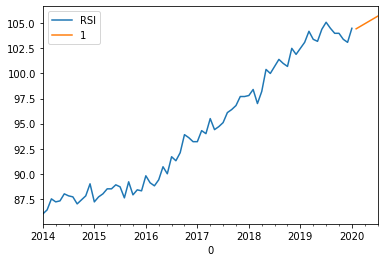

In [106]:
import pandas as pd

rsi = pd.read_csv("./data/rsi_before.csv", index_col="Date", parse_dates=True) # Load data
rsi_prediction = pd.DataFrame(predictions).set_index(0) # Move timestamp to index
rsi_prediction.index = pd.to_datetime(rsi_prediction.index) # Parse timestamp
ax = rsi.plot()
rsi_prediction.plot(ax=ax)

Not too bad ehy? Minor blip in the last couple of months in 2019, but sentiment continues to be positive...

> BUT WAIT...
> 
> WHAT IS... GOING ON...
> 
> WHY...
> 
> UH OH...

/Users/phil/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<AxesSubplot:xlabel='0'>

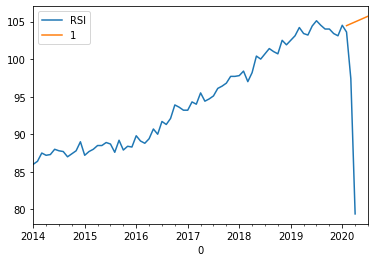

In [107]:
rsi = pd.read_csv("./data/rsi_mid.csv", index_col="Date", parse_dates=True) # Load more recent data
rsi_prediction = pd.DataFrame(predictions).set_index(0)
rsi_prediction.index = pd.to_datetime(rsi_prediction.index)
ax = rsi.plot()
rsi_prediction.plot(ax=ax)

## 7. Panic-Driven Manual Deploys Always Fail

Yes, Coronavirus happened. It's the latest in a string of many so-called "1-in-100 year events" and affected nearly every aspect of life.

Thankfully, in our wisdom, we have a pipeline. All we need to do is to stream the data into our training data repository, then watch the deployment bloom. Don't Panic!

In [108]:
!cd data && pachctl put file rsi_data@master:/rsi.csv -f rsi_mid.csv --overwrite

rsi_mid.csv: 1.22 KiB / 1.22 KiB [============================] 100.00% ? p/s 0s


In [111]:
!pachctl list pipeline
!pachctl list job
!kubectl rollout status deployment -n seldon rsi-predictor-default-0-rsi-predictor

NAME         VERSION INPUT          CREATED            STATE / LAST JOB  DESCRIPTION                                                                    
rsi_deploy   1       rsi_training:/ About a minute ago running / success A pipeline deploys a seldon core model using the most recent model parameters. 
rsi_training 1       rsi_data:/     About a minute ago running / success A pipeline that trains a statsmodels model based on the provided input data.   
ID                               PIPELINE     STARTED            DURATION  RESTART PROGRESS  DL       UL       STATE   
3952150e4c294a1d9702ff790966ca8a rsi_deploy   15 seconds ago     2 seconds 0       1 + 0 / 1 16.23KiB 0B       success 
7af818fe71ed4d2e90c9a56c42aabed5 rsi_training 18 seconds ago     2 seconds 0       1 + 0 / 1 1.221KiB 16.23KiB success 
61e0dd166c1c41499cb064d4ade222a4 rsi_deploy   58 seconds ago     2 seconds 0       1 + 0 / 1 15.9KiB  0B       success 
0e689e1838ec4b499eb57c10bad4c391 rsi_training About a minute 

In [112]:
get_metadata()
predictions = get_predictions(6)

200
{'graphinputs': [{'messagetype': 'ndarray',
                  'schema': {'names': ['periods'], 'shape': [1]}}],
 'graphoutputs': [{'messagetype': 'ndarray', 'schema': {'shape': [2]}}],
 'models': {'rsi-predictor': {'custom': {'MODEL_COMMIT_HASH': 'f6d17cefdfe94c1f96b1bab58fdef9db',
                                         'MODEL_URI': 's3://master.rsi_training/model.joblib'},
                              'inputs': [{'messagetype': 'ndarray',
                                          'schema': {'names': ['periods'],
                                                     'shape': [1]}}],
                              'name': 'RSIModel',
                              'outputs': [{'messagetype': 'ndarray',
                                           'schema': {'shape': [2]}}],
                              'platform': 'seldon',
                              'versions': ['s3://master.rsi_training/model.joblib@f6d17cefdfe94c1f96b1bab58fdef9db']}},
 'name': 'default'}
200
{'data': {'names':

First, notice the commit hash in the metadata. See that it has changed. Your old model still exists in the repo, but it's not at the tip any more.

Secondly, let's look at the predictions now...

/Users/phil/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<AxesSubplot:xlabel='0'>

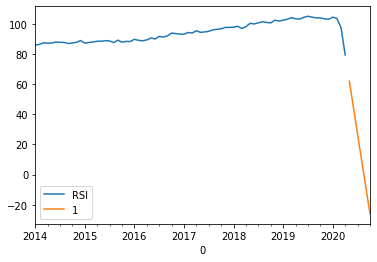

In [113]:
rsi = pd.read_csv("./data/rsi_mid.csv", index_col="Date", parse_dates=True)
rsi_prediction = pd.DataFrame(predictions).set_index(0)
rsi_prediction.index = pd.to_datetime(rsi_prediction.index)
ax = rsi.plot()
rsi_prediction.plot(ax=ax)

Oh dear! Negative RSI's that's not right! This highlights that our model isn't fit for purpose any more, but that's a conversation for another day.

After some time, we get more data...

In [114]:
!cd data && pachctl put file rsi_data@master:/rsi.csv -f rsi_after.csv --overwrite

rsi_after.csv: 1.32 KiB / 1.32 KiB [==========================] 100.00% ? p/s 0s


In [116]:
!pachctl list pipeline
!pachctl list job
!kubectl rollout status deployment -n seldon rsi-predictor-default-0-rsi-predictor

NAME         VERSION INPUT          CREATED            STATE / LAST JOB  DESCRIPTION                                                                    
rsi_deploy   1       rsi_training:/ About a minute ago running / success A pipeline deploys a seldon core model using the most recent model parameters. 
rsi_training 1       rsi_data:/     About a minute ago running / success A pipeline that trains a statsmodels model based on the provided input data.   
ID                               PIPELINE     STARTED            DURATION  RESTART PROGRESS  DL       UL       STATE   
97e8589ed2624d43b6fea7ac982ed710 rsi_deploy   5 seconds ago      2 seconds 0       1 + 0 / 1 16.88KiB 0B       success 
b123e245235b48bea8f2bd81b13a38de rsi_training 8 seconds ago      2 seconds 0       1 + 0 / 1 1.319KiB 16.88KiB success 
3952150e4c294a1d9702ff790966ca8a rsi_deploy   45 seconds ago     2 seconds 0       1 + 0 / 1 16.23KiB 0B       success 
7af818fe71ed4d2e90c9a56c42aabed5 rsi_training 48 seconds ago 

In [118]:
get_metadata()
predictions = get_predictions(6)

200
{'graphinputs': [{'messagetype': 'ndarray',
                  'schema': {'names': ['periods'], 'shape': [1]}}],
 'graphoutputs': [{'messagetype': 'ndarray', 'schema': {'shape': [2]}}],
 'models': {'rsi-predictor': {'custom': {'MODEL_COMMIT_HASH': 'a3649690959640758852a21fbab8d05e',
                                         'MODEL_URI': 's3://master.rsi_training/model.joblib'},
                              'inputs': [{'messagetype': 'ndarray',
                                          'schema': {'names': ['periods'],
                                                     'shape': [1]}}],
                              'name': 'RSIModel',
                              'outputs': [{'messagetype': 'ndarray',
                                           'schema': {'shape': [2]}}],
                              'platform': 'seldon',
                              'versions': ['s3://master.rsi_training/model.joblib@a3649690959640758852a21fbab8d05e']}},
 'name': 'default'}
200
{'data': {'names':

/Users/phil/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<AxesSubplot:xlabel='0'>

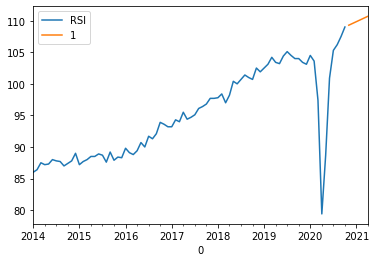

In [119]:
rsi = pd.read_csv("./data/rsi_after.csv", index_col="Date", parse_dates=True)
rsi_prediction = pd.DataFrame(predictions).set_index(0)
rsi_prediction.index = pd.to_datetime(rsi_prediction.index)
ax = rsi.plot()
rsi_prediction.plot(ax=ax)

And we're looking ok again. Shaken, but we made it through.

## Summary

In this example you have encoded the Seldon deployment into a Pachyderm pipeline. This provides clear, simple provenance and lineage between the data (version controlled) and the deployed model (also version controlled).

There's an argument to be made that Pachyderm isn't a fully fledged CD system. And that's true, you don't get all of the niceties that they provide. But I like how close the deployment is to the data; it's much easier to reason about end-to-end applications when all the components are close together.

Another option is to simply call your CD system from the Pachyderm pipeline, rather than doing the deployment directly. This still gives you the benefit of having data-driven deployments, but at the same time, the rigour of a CD system.